# Model Selection
Now that we've implemented user-based collaborative filtering (UBCF), and both a self-implemented SVD model as well as the SVD model from `surprise`, we can finally compare the models across the board. As we saw from the previous notebooks, user-based CF performs much worse than either SVD 

In [1]:
%%capture
import sys
import os

# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
# import packages
from utils.imports import *
# import user-defined funcs and classes
from utils.helpers import *
from models.UserBasedCF import UserBasedCF
from models.ManualSVD import ManualSVD

In [2]:
# import pandas dataframes
with open("../data/dataframes.pkl", "rb") as f:
    data = pickle.load(f)

train = data["train"]
validation = data["validation"]
baseline = data["baseline"]

# load sparse matrix
ui_csr = load_npz("../data/ui_csr.npz")

# load encodings
with open("../artifacts/user_encoder.pkl", "rb") as f:
    user_encoder = pickle.load(f)
with open("../artifacts/item_encoder.pkl", "rb") as f:
    item_encoder = pickle.load(f)
with open("../artifacts/user_map.pkl", "rb") as f:
    user_map = pickle.load(f)
with open("../artifacts/item_map.pkl", "rb") as f:
    item_map = pickle.load(f)

# load user CF
with open("../artifacts/user_CF.pkl", "rb") as f:
    user_CF = pickle.load(f)

# load user SVD models/data
with open("../artifacts/models.pkl", "rb") as f:
    models = pickle.load(f)
with open("../data/grid_search.pkl", "rb") as f:
    grid_search = pickle.load(f)

# load surprise models/data
with open("../artifacts/surprise_models.pkl", "rb") as f:
    surprise_models = pickle.load(f)
with open("../data/surprise_grid_search.pkl", "rb") as f:
    surprise_grid_search = pickle.load(f)  


/Users/Kitsuragi/Desktop/Code/Beer-Project/.venv3_9/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Training/Validation Performance (candidate model selection)
### User-Based CF

#### Prediction Accuracy Metrics
We'll evaluate user-based CF over different choices of k.

In [4]:
# let's experiment with different values of k
k_values = [3, 5, 10, 20, 50, 100]
for k in k_values:
    RMSE, MAE = user_CF.evaluate_error(validation, k)
    print(f'The RMSE for user-based CF with {k}-NN is '
          f'{RMSE}')
    print(f'The MAE for user-based CF with {k}-NN is '
          f'{MAE}')
    print('\n')

The RMSE for user-based CF with 3-NN is 0.8281375351604974
The MAE for user-based CF with 3-NN is 0.6062849787578912


The RMSE for user-based CF with 5-NN is 0.7948962457823016
The MAE for user-based CF with 5-NN is 0.5767247519566189


The RMSE for user-based CF with 10-NN is 0.7731675049216724
The MAE for user-based CF with 10-NN is 0.555877013054669


The RMSE for user-based CF with 20-NN is 0.766080997095158
The MAE for user-based CF with 20-NN is 0.5465076312264295


The RMSE for user-based CF with 50-NN is 0.7604301674859361
The MAE for user-based CF with 50-NN is 0.5415636400772108


The RMSE for user-based CF with 100-NN is 0.7582446812298936
The MAE for user-based CF with 100-NN is 0.5399732653019377




#### Top-N Predictions/Coverage
We're not only interested in prediction accuracy; we'd also like to know how effective our algorithm is at predicting novel or less popular items. To measure this, we'll look at the top-N items as calculated by taking the $N$ items for a user with the highest predicted ratings. To avoid interminable runtime, we'll use a a fast matrix-based function which precomputes the most similar neighbours for each user (not for a user-item pair).


In [5]:
k_values = [3, 5, 10, 20]
N = 10

for k in k_values:
    cov = user_CF.coverage_at_N(k, N)
    print(f'For k = {k} nearest neighbours and top-{N} beers recommended:')
    print(f'The number of recommended beers over all users is {cov[1]}')
    print(f'This corresponds to {cov[0]}% '
        'of all beers in the training matrix.\n')

For k = 3 nearest neighbours and top-10 beers recommended:
The number of recommended beers over all users is 6497
This corresponds to 24.88% of all beers in the training matrix.

For k = 5 nearest neighbours and top-10 beers recommended:
The number of recommended beers over all users is 6128
This corresponds to 23.47% of all beers in the training matrix.

For k = 10 nearest neighbours and top-10 beers recommended:
The number of recommended beers over all users is 5035
This corresponds to 19.28% of all beers in the training matrix.

For k = 20 nearest neighbours and top-10 beers recommended:
The number of recommended beers over all users is 3814
This corresponds to 14.61% of all beers in the training matrix.



It's worth mentioning that this experiment does not tell the entire story when it comes to recommending items from a catalog. This simple user-based CF model is only capable of recommending beers which have been reviewed at least three times - this already excludes the many beers which have only been reviewed once or twice. This is in addition to the fact that the system is only likely to recommend a fraction of the total available beers as demonstrated by the above code. We can investigate how recommendations differ given different neighbourhood sizes.

In [6]:
# set params
user, k, N = 69, 3, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_beerid                                  beer_name  \
                                                           
0         276                     Sierra Nevada Pale Ale   
1         665                         Anchor Liberty Ale   
2        3842                     Trappistes Rochefort 6   
3       21498  Dog & Pony Double Dry-hopped Imperial IPA   
4       21499                                      Julöl   
5       21502                           Dusty Trail Pale   
6       21505                         Lammin Kataja Olut   
7       21514                           Premium Pilsener   
8       21515                            Haake Beck Pils   
9       21519                      Smoky Mountain Porter   

                       brewery_name                      beer_style  \
                                                                      
0         Sierra Nevada Brewing Co.         American Pale Ale (APA)   
1            Anchor Brewing Company         American Pale Ale (APA)   
2            Brasserie de Rochefort         Belgian Strong Dark Ale   
3  Maritime Pacific Brewing Company  American Double / Imperial IPA   
4               Grebbestad Bryggeri                    Vienna Lager   
5                   Amnesia Brewing         American Pale Ale (APA)   
6                   Lammin Sahti Oy                           Sahti   
7          Brauerei Herrenhausen KG                 German Pilsener   
8               Brauerei Beck & Co.                 German Pilsener   
9  Natty Greene's Pub & Brewing Co.                 American Porter   

  review_overall                 beer_abv  
            mean count       std     mean  
0       4.248130  2406  0.529726      5.6  
1       4.096070  1374  0.540642      6.0  
2       4.138889   756  0.511350      7.5  
3       3.900000     5  0.223607      7.5  
4       3.625000     4  0.478714      5.3  
5       3.300000     5  0.670820      5.2  
6       3.150485   103  0.756783      7.0  
7       3.500000     3  0.000000      4.9  
8       3.250000     4  0.645497      4.9  
9       4.208333    12  0.257464      5.1

In [7]:
# set params
user, k, N = 69, 20, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_beerid                         beer_name  \
                                                  
0         276            Sierra Nevada Pale Ale   
1        1093                   Two Hearted Ale   
2        1118                   Chocolate Stout   
3        2233                 Summit Winter Ale   
4        3646           Urthel Hibernus Quentum   
5        6947  Cuvée Van De Keizer Blauw (Blue)   
6       14916                        Hop Wallop   
7       18862                      Burton Baton   
8       27265                 Bell's Wheat Love   
9       35405        Victor's MemoriAle Altbier   

                      brewery_name                      beer_style  \
                                                                     
0        Sierra Nevada Brewing Co.         American Pale Ale (APA)   
1             Bell's Brewery, Inc.                    American IPA   
2                       Rogue Ales                  American Stout   
3           Summit Brewing Company                   Winter Warmer   
4  De Leyerth Brouwerijen (Urthel)                          Tripel   
5              Brouwerij Het Anker         Belgian Strong Dark Ale   
6          Victory Brewing Company  American Double / Imperial IPA   
7             Dogfish Head Brewery  American Double / Imperial IPA   
8             Bell's Brewery, Inc.                       Wheatwine   
9     Two Brothers Brewing Company                         Altbier   

  review_overall                 beer_abv  
            mean count       std     mean  
0       4.248130  2406  0.529726      5.6  
1       4.320482  2529  0.506680      7.0  
2       4.115407  1733  0.592690      6.0  
3       3.791489   235  0.494772      6.1  
4       4.038462   221  0.543236      9.0  
5       4.145920   723  0.594126     11.0  
6       3.987629  1738  0.606045      8.5  
7       4.010145  1380  0.557992     10.0  
8       3.983553   152  0.547171      7.7  
9       4.095238    42  0.508922      7.8

In [8]:
# set params
user, k, N = 420, 3, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_beerid                             beer_name  \
                                                      
0         142                  Ommegang (Abbey Ale)   
1         226  Great Lakes Edmund Fitzgerald Porter   
2         228           Great Lakes Dortmunder Gold   
3         760     Weihenstephaner Kristallweissbier   
4         773                            Goudenband   
5        1385                      Delirium Tremens   
6       38366             Samuel Adams Dunkelweizen   
7       62328          Estate Homegrown Wet Hop Ale   
8       67262               Longshot Blackened Hops   
9       67267                Longshot Friar Hop Ale   

                              brewery_name                 beer_style  \
                                                                        
0                         Brewery Ommegang                     Dubbel   
1              Great Lakes Brewing Company            American Porter   
2              Great Lakes Brewing Company  Dortmunder / Export Lager   
3  Bayerische Staatsbrauerei Weihenstephan              Kristalweizen   
4                       Brouwerij Liefmans         Flanders Oud Bruin   
5                         Brouwerij Huyghe    Belgian Strong Pale Ale   
6       Boston Beer Company (Samuel Adams)               Dunkelweizen   
7                Sierra Nevada Brewing Co.               American IPA   
8       Boston Beer Company (Samuel Adams)         American Black Ale   
9       Boston Beer Company (Samuel Adams)                Belgian IPA   

  review_overall                 beer_abv  
            mean count       std     mean  
0       4.040414  1497  0.591441      8.5  
1       4.322813  1600  0.466191      5.8  
2       4.290899   868  0.499479      5.8  
3       4.168576   611  0.512366      5.4  
4       4.133333   465  0.576541      8.0  
5       4.022912  1353  0.589786      8.5  
6       3.680000   275  0.553159      5.1  
7       4.134085   399  0.441493      6.7  
8       3.924731   186  0.467577      7.0  
9       3.591892   185  0.561141      9.0

In [9]:
# set params
user, k, N = 420, 20, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_beerid                                 beer_name  \
                                                          
0         131             Ayinger Celebrator Doppelbock   
1         226      Great Lakes Edmund Fitzgerald Porter   
2         646                 Westmalle Trappist Tripel   
3        1287                             Bell's Porter   
4        2751                    Racer 5 India Pale Ale   
5        5428  New Holland Dragon's Milk Oak Barrel Ale   
6       10325     Péché Mortel (Imperial Stout Au Cafe)   
7       11922                                 Titan IPA   
8       19216              Oak Aged Yeti Imperial Stout   
9       25755      Heavy Seas - Loose Cannon (Hop3 Ale)   

                                        brewery_name  \
                                                       
0  Privatbrauerei Franz Inselkammer KG / Brauerei...   
1                        Great Lakes Brewing Company   
2                                Brouwerij Westmalle   
3                               Bell's Brewery, Inc.   
4                          Bear Republic Brewing Co.   
5                        New Holland Brewing Company   
6                             Brasserie Dieu Du Ciel   
7                       Great Divide Brewing Company   
8                       Great Divide Brewing Company   
9                                    Heavy Seas Beer   

                         beer_style review_overall                 beer_abv  
                                              mean count       std     mean  
0                        Doppelbock       4.293592  2013  0.513722     6.70  
1                   American Porter       4.322813  1600  0.466191     5.80  
2                            Tripel       4.196698  1393  0.549363     9.50  
3                   American Porter       3.985976   820  0.517801     5.60  
4                      American IPA       4.229022  1871  0.472854     7.00  
5                    American Stout       3.762470   842  0.654713    10.00  
6  American Double / Imperial Stout       4.264685  1396  0.528709     9.50  
7                      American IPA       4.137327  1227  0.494349     7.10  
8            Russian Imperial Stout       4.082671  1385  0.551066     9.50  
9                      American IPA       4.073559  1006  0.473220     7.25

We can see clearly that increasing the neighbourhood size tends to recommend more popular beers. This effect is commonly observed when implementing user-based CF. We can think critically about why this may be. When generating recommendations from a small number of neighbours, we only take the recommendations from the most similar users - and their "votes" towards recommendations have a very large impact on the predicted items. Therefore, a more rare and polarizing beer may be recommended to a user when using a small value for k if that user's closest neighbours give it a high score. Conversely, including a larger number of neighbours when generating predictions tends to push predicted scores towards the mean; more rare and polarizing beers will tend to get pushed out by popular and highly-rated beers. The "signal" from similar users will be lost. As we saw from the EDA, there are a relatively small number of highly-rated and highly-reviewed beers. Continuing to increase the value of k will lead to those beers being recommended:

In [10]:
# set params, make k big
user, k, N = 420, 500, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_beerid                                          beer_name  \
                                                                   
0         131                      Ayinger Celebrator Doppelbock   
1         141                        Hennepin (Farmhouse Saison)   
2         226               Great Lakes Edmund Fitzgerald Porter   
3        2751                             Racer 5 India Pale Ale   
4        3457  Three Philosophers Belgian Style Blend (Quadru...   
5        6518                                    Dale's Pale Ale   
6       10325              Péché Mortel (Imperial Stout Au Cafe)   
7       11922                                          Titan IPA   
8       16403                       Smuttynose IPA "Finest Kind"   
9       19216                       Oak Aged Yeti Imperial Stout   

                                        brewery_name  \
                                                       
0  Privatbrauerei Franz Inselkammer KG / Brauerei...   
1                                   Brewery Ommegang   
2                        Great Lakes Brewing Company   
3                          Bear Republic Brewing Co.   
4                                   Brewery Ommegang   
5                           Oskar Blues Grill & Brew   
6                             Brasserie Dieu Du Ciel   
7                       Great Divide Brewing Company   
8                         Smuttynose Brewing Company   
9                       Great Divide Brewing Company   

                         beer_style review_overall                 beer_abv  
                                              mean count       std     mean  
0                        Doppelbock       4.293592  2013  0.513722      6.7  
1            Saison / Farmhouse Ale       4.243311  1794  0.509828      7.7  
2                   American Porter       4.322813  1600  0.466191      5.8  
3                      American IPA       4.229022  1871  0.472854      7.0  
4                  Quadrupel (Quad)       3.981173  1620  0.564645      9.8  
5           American Pale Ale (APA)       4.070605  1388  0.544409      6.5  
6  American Double / Imperial Stout       4.264685  1396  0.528709      9.5  
7                      American IPA       4.137327  1227  0.494349      7.1  
8                      American IPA       4.124649  1424  0.577223      6.9  
9            Russian Imperial Stout       4.082671  1385  0.551066      9.5

All of these beers are among the most popular and well-liked beers on the site. This demonstrates why it's not beneficial to choose a large value of k simply because it results in a low RMSE; in the context of an item catalog, a recommender should be capable of providing personalized and novel recommendations.

## ManualSVD and `surprise` SVD

After fitting the SVD models, we recorded evaluation metrics, i.e. RMSE, accuracy, and top-10 item coverage. We show the findings below:

In [11]:
grid_search

,reg,k,RMSE,MAE,coverage
0,0.001,25.0,0.695346,0.519892,0.3538
1,0.020,25.0,0.694154,0.518850,0.4916
2,0.100,25.0,0.694280,0.519967,0.4477
3,0.001,50.0,0.700073,0.523750,0.6420
4,0.020,50.0,0.697587,0.521623,0.7154
5,0.100,50.0,0.696014,0.521280,0.6117
6,0.001,75.0,0.703593,0.526346,0.7800
7,0.020,75.0,0.698776,0.522344,0.7949
8,0.100,75.0,0.696006,0.520970,0.6626
9,0.001,100.0,0.703614,0.527351,0.8407


In [12]:
surprise_grid_search

,reg,k,RMSE,MAE,coverage
0,0.001,25.0,0.709072,0.502870,0.132713
1,0.020,25.0,0.706679,0.501141,0.433490
2,0.100,25.0,0.707021,0.502178,0.428725
3,0.001,50.0,0.712453,0.506189,0.212365
4,0.020,50.0,0.708865,0.502766,0.648659
5,0.100,50.0,0.706667,0.501452,0.579459
6,0.001,75.0,0.715383,0.509369,0.289941
7,0.020,75.0,0.711080,0.504909,0.752939
8,0.100,75.0,0.707681,0.502662,0.634750
9,0.001,100.0,0.715250,0.509542,0.357066


Text(0.5, 1.0, 'Surprise SVD')

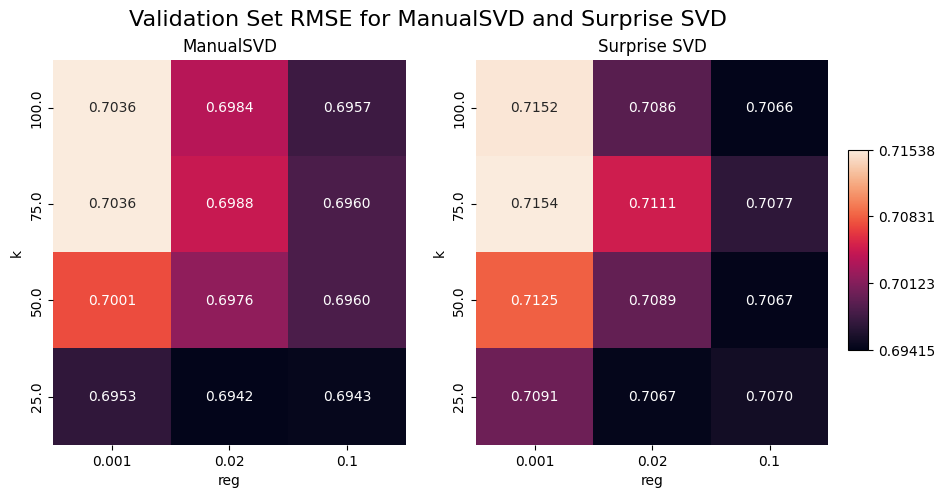

In [13]:
fig, axes = plot_comparison_heatmap(grid_search, surprise_grid_search, "RMSE")
fig.suptitle("Validation Set RMSE for ManualSVD and Surprise SVD", fontsize=16)
axes[0].set_title("ManualSVD")
axes[1].set_title("Surprise SVD")

Text(0.5, 1.0, 'Surprise SVD')

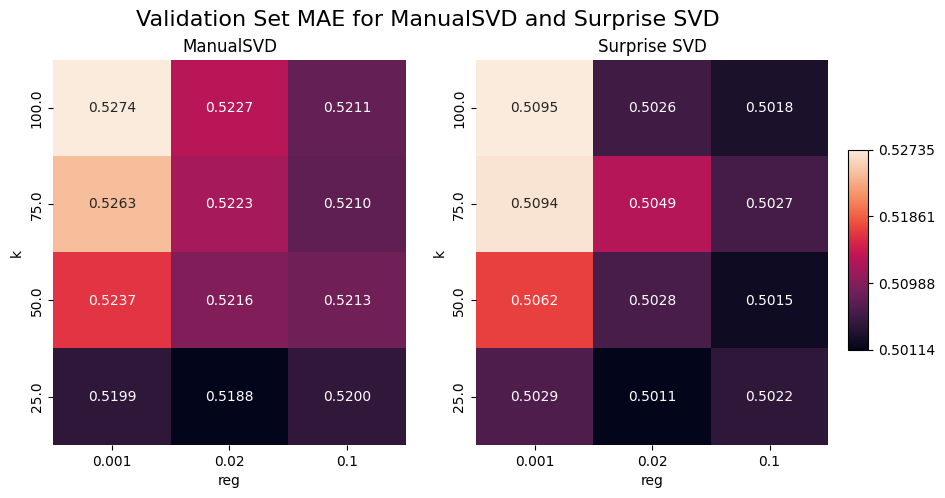

In [14]:
fig, axes = plot_comparison_heatmap(grid_search, surprise_grid_search, "MAE")
fig.suptitle("Validation Set MAE for ManualSVD and Surprise SVD", fontsize=16)
axes[0].set_title("ManualSVD")
axes[1].set_title("Surprise SVD")

Text(0.5, 1.0, 'Surprise SVD')

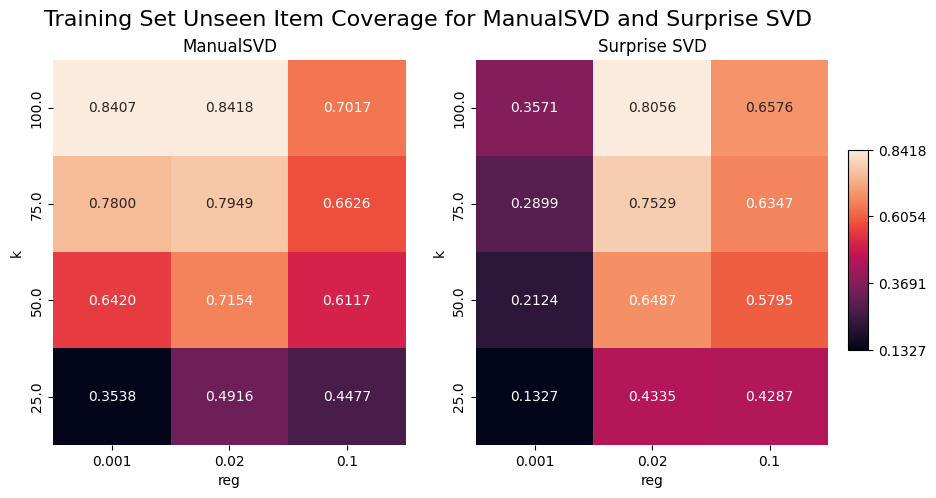

In [15]:
fig, axes = plot_comparison_heatmap(grid_search, surprise_grid_search, "coverage")
fig.suptitle("Training Set Unseen Item Coverage for ManualSVD and Surprise SVD", fontsize=16)
axes[0].set_title("ManualSVD")
axes[1].set_title("Surprise SVD")

In [3]:
model = ManualSVD(k=50, reg_bias=0.2, bias_lr=0.003, latent_lr=0.01, reg_latent=0.005)
model.fit(ui_csr, validation, verbose=True)

Iteration: 1
current validation RMSE: 0.7428611635903809
Iteration: 2
current validation RMSE: 0.7312576330278103
Iteration: 3
current validation RMSE: 0.7247474020447329
Iteration: 4
current validation RMSE: 0.7202767891560623
Iteration: 5
current validation RMSE: 0.7169960476547267
Iteration: 6
current validation RMSE: 0.7140636030021739
Iteration: 7
current validation RMSE: 0.7120282687196405
Iteration: 8
current validation RMSE: 0.7103971264703496
Iteration: 9
current validation RMSE: 0.7091242977951506
Iteration: 10
current validation RMSE: 0.7082033918823923
Iteration: 11
current validation RMSE: 0.707464085065807
Final validation RMSE is: 0.7070555323416089

Stopped after 12 iterations


In [4]:
get_beer_data(baseline, model.get_top_N(N=10, biases=False, a=0.3)[154], item_encoder)

beer_beerid                          beer_name  \
                                                   
0          65                          Budweiser   
1         332                        Miller Lite   
2         580                   Miller High Life   
3         696                           Pale Ale   
4         754                   Guinness Draught   
5        1331            Pabst Blue Ribbon (PBR)   
6        1341                     Keystone Light   
7        1524                      Natural Light   
8        5406  Florisgaarden Chocolat Gardenbeer   
9       51761       Unplugged Old English Porter   

                    brewery_name              beer_style review_overall        \
                                                                   mean count   
0                 Anheuser-Busch  American Adjunct Lager       2.856716  1340   
1             Miller Brewing Co.             Light Lager       2.739879   988   
2             Miller Brewing Co.  American Adjunct Lager       3.332090   938   
3  Ballast Point Brewing Company                  Kölsch       3.715613   269   
4                  Guinness Ltd.         Irish Dry Stout       3.656300  1865   
5          Pabst Brewing Company  American Adjunct Lager       3.572537  1289   
6          Coors Brewing Company             Light Lager       2.531328   399   
7                 Anheuser-Busch             Light Lager       2.384279   458   
8               Brouwerij Huyghe        Belgian Dark Ale       2.460000    25   
9     New Glarus Brewing Company          English Porter       3.624402   209   

            beer_abv  
        std     mean  
0  1.012244     5.00  
1  0.996523     4.17  
2  0.899902     5.00  
3  0.731729     5.00  
4  0.855489     4.20  
5  0.829141     4.74  
6  1.073152     4.20  
7  1.119615     4.20  
8  1.059874     4.20  
9  0.852783     5.50

In [18]:
get_beer_data(baseline, user_CF.top_N_beers(user=11, k=20, N=10))

beer_beerid                           beer_name  \
                                                    
0          63                   Anchor Steam Beer   
1        1361         Ayinger Oktober Fest-Märzen   
2        1381               Yuengling Black & Tan   
3        1590                    Penn Oktoberfest   
4        1708                St. Bernardus Abt 12   
5        1904       Sierra Nevada Celebration Ale   
6        1999                       Christmas Ale   
7        4108                Tröegs Sunshine Pils   
8       16403        Smuttynose IPA "Finest Kind"   
9       38470  Stone Sublimely Self-Righteous Ale   

                                        brewery_name  \
                                                       
0                             Anchor Brewing Company   
1  Privatbrauerei Franz Inselkammer KG / Brauerei...   
2                                 Yuengling Brewery    
3                       Pennsylvania Brewing Company   
4                         Brouwerij St. Bernardus NV   
5                          Sierra Nevada Brewing Co.   
6                              Goose Island Beer Co.   
7                             Tröegs Brewing Company   
8                         Smuttynose Brewing Company   
9                                  Stone Brewing Co.   

                       beer_style review_overall                 beer_abv  
                                            mean count       std     mean  
0  California Common / Steam Beer       4.059609  1686  0.569116      4.9  
1            Märzen / Oktoberfest       4.014128   814  0.576377      5.8  
2                     Black & Tan       3.478741   588  0.720808      4.7  
3            Märzen / Oktoberfest       3.952899   138  0.569568      5.6  
4                Quadrupel (Quad)       4.324894  2113  0.501282     10.0  
5                    American IPA       4.162411  2820  0.553173      6.8  
6              American Brown Ale       3.854031   459  0.532195      6.2  
7                 German Pilsener       4.063976   508  0.631474      5.3  
8                    American IPA       4.124649  1424  0.577223      6.9  
9              American Black Ale       4.093101  1493  0.521044      8.7

In [19]:
baseline[baseline['user_idx'] == 11]

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,user_idx,item_idx
176350,94,Long Trail Brewing Co.,1324594131,4.0,4.5,4.0,11millsown113,English India Pale Ale (IPA),4.0,3.5,IPA,5.9,270,11,187
174726,94,Long Trail Brewing Co.,1324592693,4.0,4.5,4.0,11millsown113,Scottish Ale,3.5,3.0,Hibernator,5.6,271,11,188
1265001,112,North Coast Brewing Co.,1324392614,4.5,4.5,4.5,11millsown113,Russian Imperial Stout,5.0,5.0,Old Rasputin Russian Imperial Stout,9.0,412,11,292
190871,2743,Green Flash Brewing Co.,1324221697,4.5,4.5,4.0,11millsown113,American Barleywine,4.5,5.0,Barleywine Style Ale,10.9,33599,11,12399
1210373,898,Heavy Seas Beer,1324742510,4.0,4.0,4.5,11millsown113,Belgian Strong Dark Ale,3.5,3.0,Heavy Seas - Holy Sheet (Über Abbey Ale),9.0,35805,11,13078
155298,3818,Southern Tier Brewing Company,1324849801,5.0,5.0,4.0,11millsown113,American Double / Imperial Stout,5.0,4.5,Choklat,11.0,40058,11,14524
1291546,15711,HaandBryggeriet,1324485266,4.5,4.5,4.5,11millsown113,Russian Imperial Stout,4.0,5.0,Odin's Tipple,11.0,50235,11,18138
1397638,22951,Clown Shoes,1324849369,4.5,2.5,4.5,11millsown113,Russian Imperial Stout,4.5,5.0,Blaecorn Unidragon,12.5,73427,11,25435
